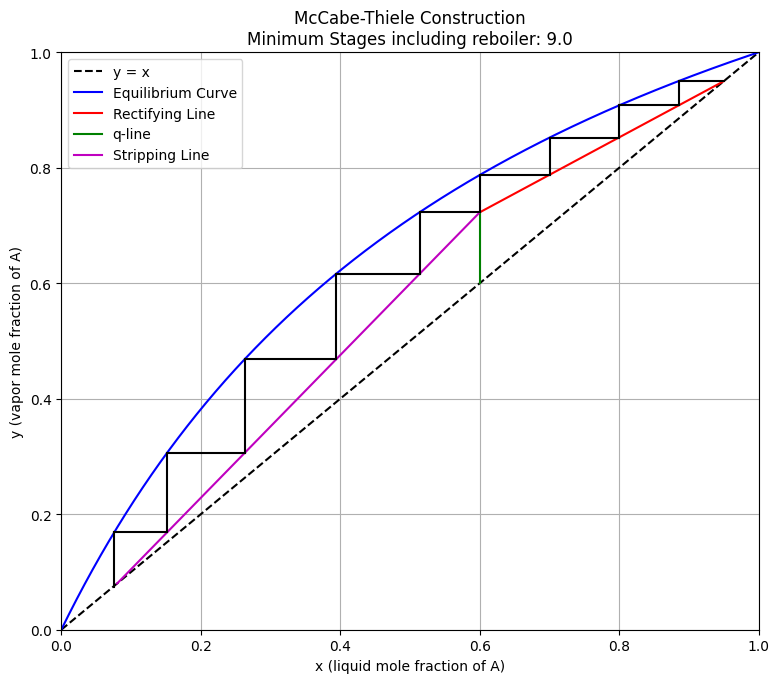

In [7]:
# Importing necessary python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk

# DEFINING MCCABE-THIELE FUNCTIONS

# Equilibrium curve
def y_eq(x, alpha):
    return (alpha * x) / (1 + (alpha - 1) * x)

# Rectifying line
def rect_line(x, R, x_D):
    return (R / (R + 1)) * x + x_D / (R + 1)

# Feed line
def q_line(x, q, x_F):
    if abs(q - 1.0) < 1e-6:
        return None                    # When q=1 the function will be handled later
    else:
        return q * x / (q - 1) - (x_F / (q - 1))

# Reverse equilibrium curve (x as a function of y)
def x_eq(y, alpha):
    return y / (alpha - y * (alpha - 1))

# Stripping line joining xB, xB with the intersection of rectifying and feed lines
def strip_line(x, x_B, y_intersection_rq, x_intersection_rq):
    m_strip = (y_intersection_rq - x_B) / (x_intersection_rq - x_B)
    c_strip = x_B - m_strip * x_B
    return m_strip * x + c_strip
    
# find the intersection of two functions of x
def find_intersection(f1, f2, x_range):  
    for x in x_range:
        if abs(f1(x) - f2(x)) < 1e-3:
            return x
    return None


# DEFINING PLOTTING FUNCTION

def plot_mccabe_thiele(alpha, x_D, x_B, x_F, q, R):
    fig, ax = plt.subplots(figsize=(9, 7.5))
    x_plot = np.linspace(0, 1, 10000)

    # Find intersection of feed line and rectifying line
    if q == 1:
        x_intersection_rq = x_F
        y_intersection_rq = rect_line(x_F, R, x_D)
    else:
        x_intersection_rq = find_intersection(
            lambda x: rect_line(x, R, x_D),
            lambda x: q_line(x, q, x_F),
            x_plot
         )
        y_intersection_rq = rect_line(x_intersection_rq, R, x_D)


    # Plot y=x
    ax.plot(x_plot, x_plot, 'k--', label='y = x')

    # Equilibrium curve
    ax.plot(x_plot, y_eq(x_plot, alpha), 'b-', label='Equilibrium Curve')

    # Rectifying line
    x_rect = np.linspace(x_intersection_rq, x_D, 500)
    ax.plot(x_rect, rect_line(x_rect, R, x_D), 'r-', label='Rectifying Line')

    # Feed line
    if q == 1:
        y_vals = np.linspace(x_F, y_intersection_rq, 500)
        x_vals = np.full_like(y_vals, x_F)                    # Creates an array of the same size and shape filled with a constant value
        ax.plot(x_vals, y_vals, 'g-', label='q-line')
    else:
        x_q = np.linspace(x_F, x_intersection_rq, 500)
        ax.plot(x_q, q_line(x_q, q, x_F), 'g-', label='Feed line')

    # Stripping line
    x_strip = np.linspace (x_B, x_intersection_rq, 500)
    ax.plot(x_strip, strip_line(x_strip, x_B, y_intersection_rq, x_intersection_rq), 'm-', label='Stripping Line')

    # Plotting stages      
    stages = 0
    x = x_D
    y = x_D

    while x > x_B:
        
        # Horizontal line to equilibrium curve
        x_new = x_eq(y, alpha)
        
        if (x_B - x_new) > 1e-2:
            frac = (x - x_B) / (x - x_new)  # Calculates fractional stages
            plt.plot([x, x_B], [y, y], 'k-')  
            stages += frac
            break
        ax.plot([x, x_new], [y, y], 'k-')
        x = x_new

        # Vertical to operating line (switching between rectifying and stripping lines)
        if x >= x_intersection_rq:
            y_new = rect_line(x, R, x_D)
        else:
            y_new = strip_line (x, x_B, y_intersection_rq, x_intersection_rq)

        ax.plot([x, x], [y, y_new], 'k-')
        y = y_new

        stages += 1
        
# Labels and Legend
    ax.set_xlabel("x (liquid mole fraction of A)")
    ax.set_ylabel("y (vapor mole fraction of A)")
    ax.set_title(f"McCabe-Thiele Construction\nMinimum Stages including reboiler: {stages:.1f}")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return fig


# GUI
def update_plot():
    try:
        alpha = float(alpha_entry.get())    # "get" reads the string in the entry box and "float" converts it to a floating point number
        x_D = float(xD_entry.get())
        x_B = float(xB_entry.get())
        x_F = float(xF_entry.get())
        q = float(q_entry.get())
        R = float(R_entry.get())
        
    except ValueError:
        return

    fig = plot_mccabe_thiele(alpha, x_D, x_B, x_F, q, R)
    canvas.figure = fig             # Assigns new figure to the canvas (canvas is a widget that allows Matplotlib plots inside Tkinter GUI)
    canvas.draw()                   # Redraws to reflect any changes

root = tk.Tk()                      # Creates the GUI window
root.title("McCabe–Thiele Calculator")
root.config(bg='light blue')

# Entry boxes and buttons

# Title for entru boxes
tk.Label(root, text="    Variables that can be changed    ", font= ("Arial",12, "bold"), bg='light blue').grid(row=0, column=0, columnspan=2)

# Alpha (relative volatility)
tk.Label(root, text="Relative Volatility", bg='light blue').grid(row=1, column=0)    # Label and its location
alpha_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")                               # Creates entry box with specified width
alpha_entry.insert(0, "2.47")                                       # Inserts a default value
alpha_entry.grid(row=1, column=1)                                   # Location of entry box

# x_D (Distillate composition)
tk.Label(root, text= "Distillate Composition   \n (Between 0 and 1)", bg='light blue').grid(row=2, column=0)
xD_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")
xD_entry.insert(0, "0.95")
xD_entry.grid(row=2, column=1)

# x_B (Bottoms composition)
tk.Label(root, text="Bottoms composition\n (Between 0 and 1)", bg='light blue').grid(row=3, column=0)
xB_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")
xB_entry.insert(0, "0.08")
xB_entry.grid(row=3, column=1)

# x_F (Feed composition)
tk.Label(root, text="Feed composition\n (Between 0 and 1)", bg='light blue').grid(row=4, column=0)
xF_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")
xF_entry.insert(0, "0.6")
xF_entry.grid(row=4, column=1)

# q (Liquid fraction of feed)
tk.Label(root, text="Liquid fraction\nof the feed", bg='light blue').grid(row=5, column=0)
q_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")
q_entry.insert(0, "1")
q_entry.grid(row=5, column=1)

# R (Reflux ratio)
tk.Label(root, text="Reflux ratio", bg='light blue').grid(row=6, column=0)
R_entry = tk.Entry(root, width=8, bd=0.5, relief="solid")
R_entry.insert(0, "1.85")
R_entry.grid(row=6, column=1)


# Plot area
fig = plot_mccabe_thiele(2.47, 0.95, 0.08, 0.6, 1, 1.85)
canvas = FigureCanvasTkAgg(fig, master=root)        # Makes a canvas inside root that has fig embedded. Child of the main window "root"
canvas.get_tk_widget().grid(row=0, column=2, rowspan=10)  # Places canvas in specified location with specified area

# Update button
tk.Button(root, text="Update Plot", command=update_plot).grid(row=7, column=0, columnspan=2)

root.mainloop()  # Event loop that keeps the GUI responsive and running until the window is closed
